In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
import sys
%matplotlib inline

sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['purchase_id'] = buy_sessions['purchase_id'].astype(int)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
products_per_day = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)

In [2]:
# Jak to uruchomisz to można znaleźć ogólny trend
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)

products_per_day=products_per_day[products_per_day['product_id']=='1007']

df=products_per_day.groupby(by=[pd.Grouper(key='date', freq="W")]).sum()

In [3]:
df

,amount
date,
2019-08-04,18
2019-08-11,1
2019-08-18,1
2019-08-25,0
2019-09-01,0
...,...
2021-11-28,0
2021-12-05,0
2021-12-12,0


<AxesSubplot:xlabel='date'>

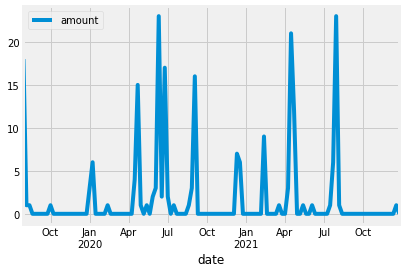

In [4]:
df.plot(y='amount',use_index=True)

In [5]:
df.index = df.index.get_level_values(0)
print(df.index)
print(type(df.index))
df

DatetimeIndex(['2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25',
               '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06',
               ...
               '2021-10-24', '2021-10-31', '2021-11-07', '2021-11-14',
               '2021-11-21', '2021-11-28', '2021-12-05', '2021-12-12',
               '2021-12-19', '2021-12-26'],
              dtype='datetime64[ns]', name='date', length=126, freq='W-SUN')
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,amount
date,
2019-08-04,18
2019-08-11,1
2019-08-18,1
2019-08-25,0
2019-09-01,0
...,...
2021-11-28,0
2021-12-05,0
2021-12-12,0


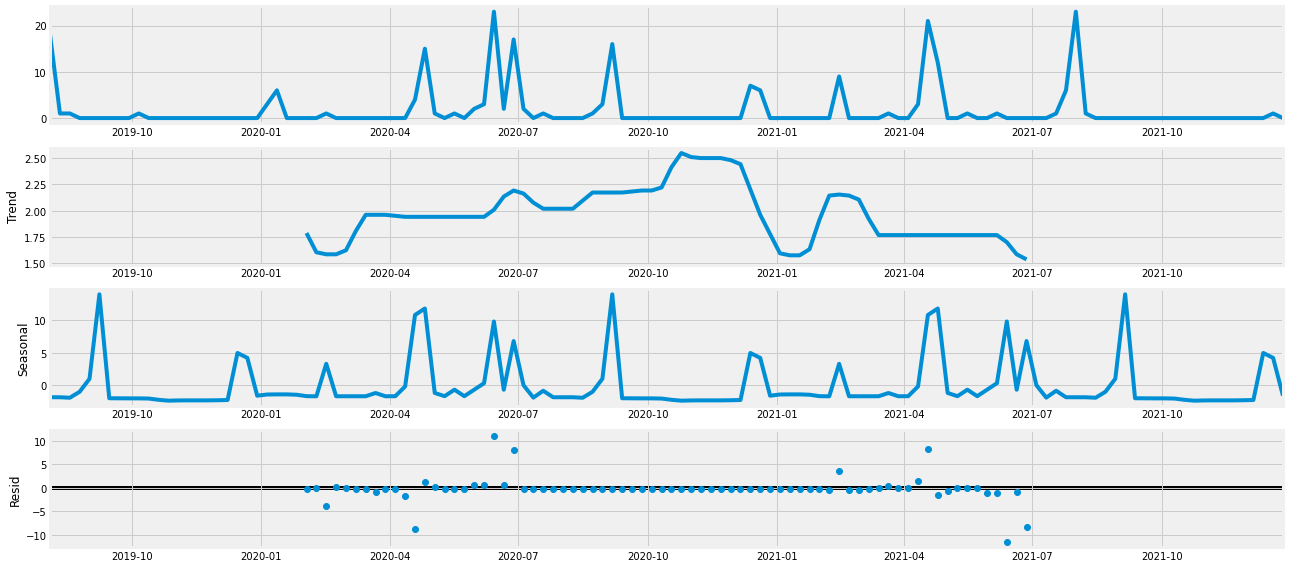

In [6]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 53) for x in list(itertools.product(p, d, q))]

In [8]:
best_aic=sys.maxsize
best_param=(1,1,1)
best_param_seasonal=(1,1,1,52)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            message='ARIMA{}x{}52 - AIC:{}'.format(param,param_seasonal,results.aic)
            print(message)
            if results.aic<best_aic:
                best_param=param
                best_param_seasonal=param_seasonal
                best_aic=results.aic
        except Exception as e: 
            print(str(e))
print("*****************")
print("Best parameters:")
print('ARIMA{}x{}52 - AIC:{}'.format(best_param,best_param_seasonal,best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 53)52 - AIC:742.1567312370037
ARIMA(0, 0, 0)x(0, 0, 1, 53)52 - AIC:430.716353461817
ARIMA(0, 0, 0)x(0, 1, 0, 53)52 - AIC:473.70433758448314
ARIMA(0, 0, 0)x(0, 1, 1, 53)52 - AIC:85.93326671551446
ARIMA(0, 0, 0)x(1, 0, 0, 53)52 - AIC:436.2971955503201
ARIMA(0, 0, 0)x(1, 0, 1, 53)52 - AIC:431.1041397919521
ARIMA(0, 0, 0)x(1, 1, 0, 53)52 - AIC:102.83571387469787
ARIMA(0, 0, 0)x(1, 1, 1, 53)52 - AIC:29.18917328947063
ARIMA(0, 0, 1)x(0, 0, 0, 53)52 - AIC:729.4075968155914
ARIMA(0, 0, 1)x(0, 0, 1, 53)52 - AIC:418.1465123650688
ARIMA(0, 0, 1)x(0, 1, 0, 53)52 - AIC:466.8538851140851
ARIMA(0, 0, 1)x(0, 1, 1, 53)52 - AIC:83.4026257635042
ARIMA(0, 0, 1)x(1, 0, 0, 53)52 - AIC:428.01417607786266
ARIMA(0, 0, 1)x(1, 0, 1, 53)52 - AIC:418.9666577450603
ARIMA(0, 0, 1)x(1, 1, 0, 53)52 - AIC:104.10618890321429
ARIMA(0, 0, 1)x(1, 1, 1, 53)52 - AIC:25.551313357747354
ARIMA(0, 1, 0)x(0, 0, 0, 53)52 - AIC:776.3432631589162
ARIMA(0, 1, 0)x(0, 0, 1, 53)52 - AIC:443.58158923963174
ARIMA(

In [9]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2634      0.375      0.703      0.482      -0.471       0.998
ma.L1         -0.0368      0.421     -0.087      0.930      -0.863       0.789
ar.S.L53      -0.8256      0.030    -27.837      0.000      -0.884      -0.767
sigma2        15.3730      2.276      6.754      0.000      10.912      19.834


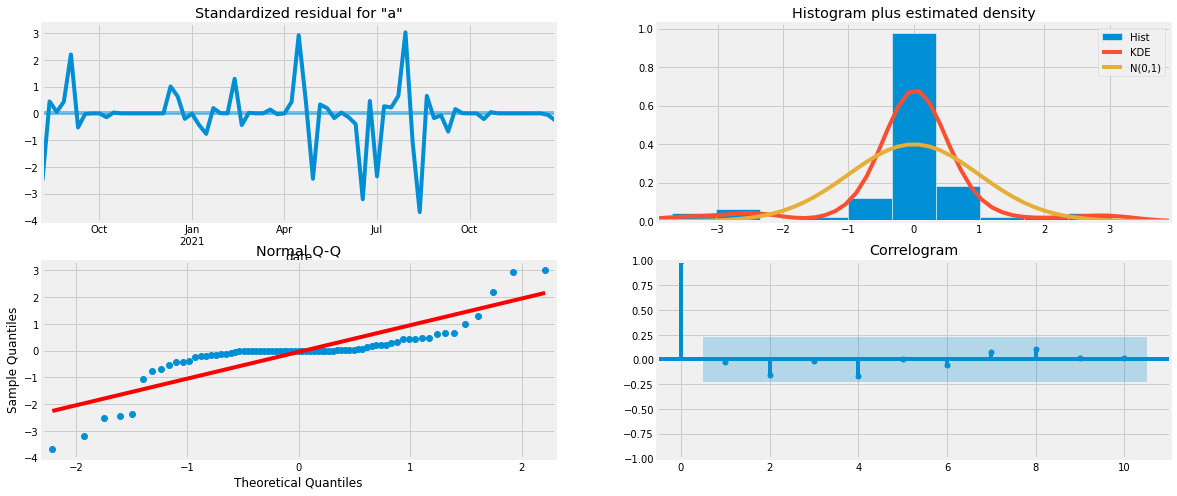

In [10]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

            amount
date              
2019-08-04      18
2019-08-11       1
2019-08-18       1
2019-08-25       0
2019-09-01       0
2019-09-08       0
2019-09-15       0
2019-09-22       0
2019-09-29       0
2019-10-06       1


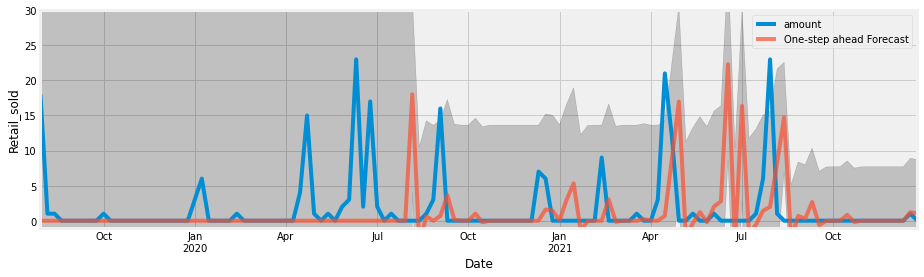

In [11]:
print(df.head(10))

pred = results.get_prediction(start=pd.to_datetime('2019-08-04'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.ylim([-1,30])
plt.legend()
plt.show()

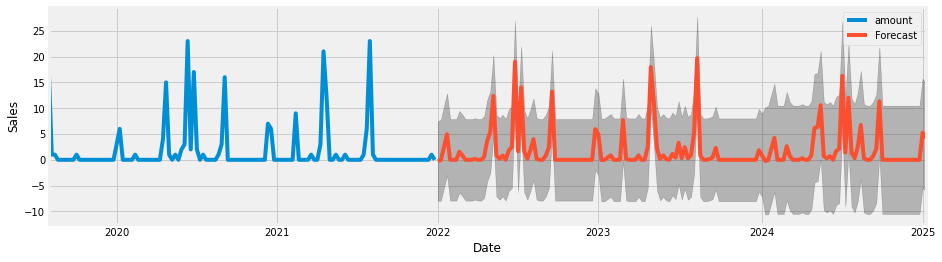

In [12]:
pred_uc = results.get_forecast(steps=159)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [13]:
## TUTAJ ZACZYNA SIĘ ARIMA, NIE WARTO TEGO RUSZAĆ CHYBA, CHYBA ŻE Z CIEKAWOŚCI - TEŻ PROSTA LINIA WYCHODZI

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['amount'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=746.833, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=747.079, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=743.404, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=744.192, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=761.210, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=745.213, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=745.311, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=751.143, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.572 seconds


In [19]:
cutoff_point=int(len(df)*0.2)
train=df[:-cutoff_point]
test=df[-cutoff_point:]
print(len(train))
print(len(test))
model=ARIMA(train['amount'],order=(1,0,0),freq='W')
model=model.fit()
model.summary()

101
25


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                  101
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -295.751
Date:                Wed, 12 Jan 2022   AIC                            597.501
Time:                        22:35:26   BIC                            605.347
Sample:                    08-04-2019   HQIC                           600.677
                         - 07-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8503      1.691      1.094      0.274      -1.463       5.164
ar.L1          0.2133      0.124      1.722      0.085      -0.029       0.456
sigma2        20.4526      3.447      5.933      0.000      13.696      27.209
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               500.48
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             3.05
Prob(H) (two-sided):                  0.15   Kurtosis:                        12.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

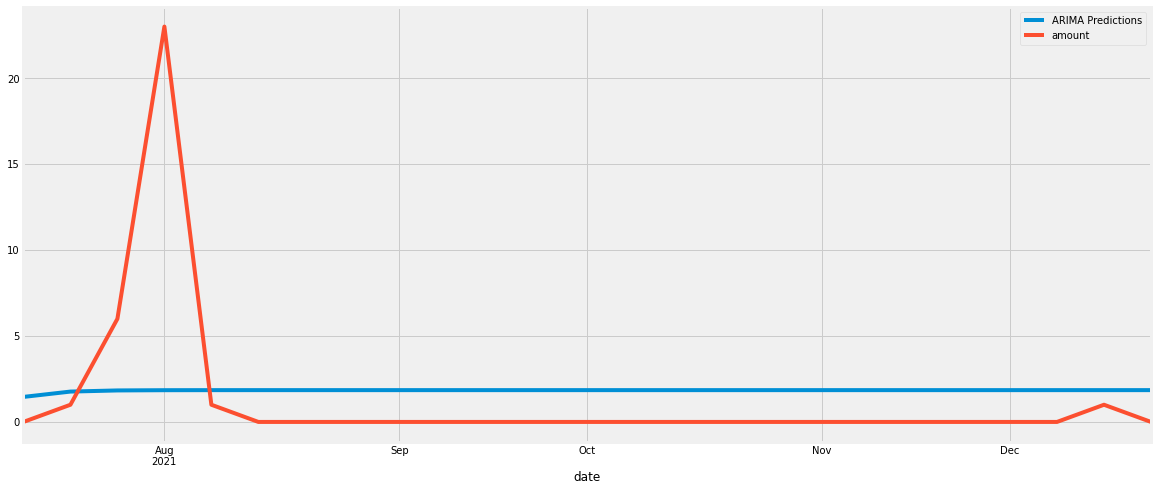

In [20]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['amount'].plot(legend=True)

<AxesSubplot:xlabel='date'>

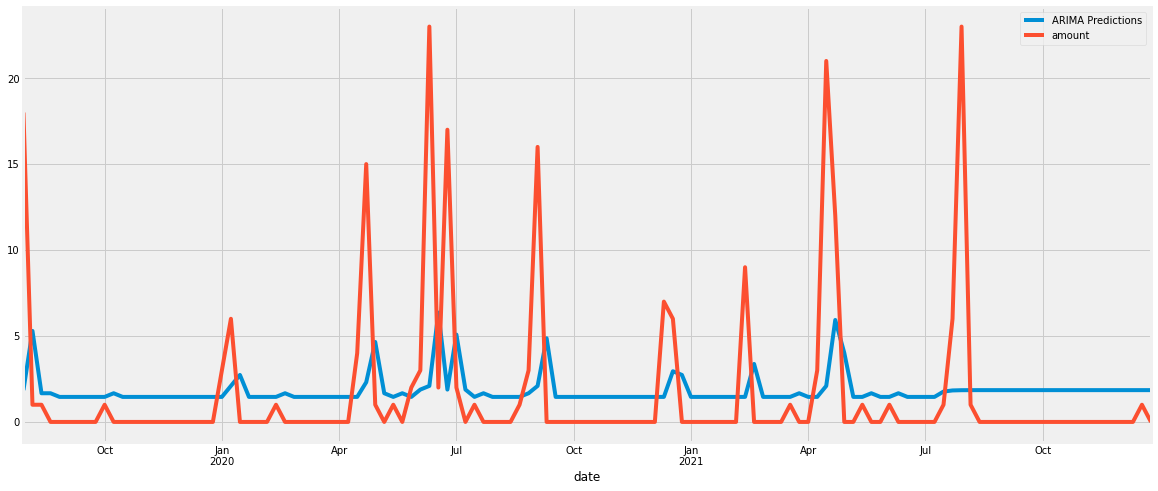

In [21]:
end=len(train)+len(test)-1
pred=model.predict(start=0,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
df['amount'].plot(legend=True)